# Pull new images from xView into ShipRS

### Preprocessing: compare and contrast the xView and ShipRS Dataset

xView is a superset of the ShipRS dataset. Each image containing the fishing vessel instance came from xView but not all xView images containing the fishing vessel instance was actually incorporated into ShipRS. ShipRS currently has about 318 instances of the fishing vessel class in its training set. xView has 799 instances in its training set which means that not all the xView images were imported. Let's find out which xView images have not yet been included so that they may have the chance to be used in the training set for improved training and more robust data. Additionally, it's important to note that (1) validation labels were not provided in the xView dataset limiting the number of availble images, and (2) there's a total of 96 images and 800+ instances of fishing vessel class in train, test, trainval, val ShipRS image sets that must be accounted for in order to eliminate duplicate data

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import json
import pandas as pd

Process each entry in ShipRS's fishing_vessel_images.txt

In [3]:
# Extract each image's "prefix"
# For example,  18__2164_920.bmp --> 18
#               1459__2760_920.bmp --> 1459 
shipRSPrefixes = set()
shipRSImages = {} # Key = image prefix | Value = a list of image paths containing this prefix

with open("fishing_vessel_shiprs.txt", "r") as f:
    lines = f.readlines()

for line in lines:
    # Extracts the sequence of numbers that come before the first "__"
    prefix = line.split("__")[0]
    
    # Keep track of the unique prefixes
    shipRSPrefixes.add(prefix)

    # Keep track of the images associated with each prefix
    if prefix not in shipRSImages:
        # First time encountering prefix
        shipRSImages[prefix] = [line[:-1]] # Remove the trailing new line character
    else:
        shipRSImages[prefix].append(line[:-1])
    
print(shipRSPrefixes)
print(shipRSImages)

{'144', '2545', '2270', '1926', '2293', '1158', '1472', '2574', '1930', '1397', '1820', '513', '2555', '2278', '1454', '1829', '18', '126', '1378', '2505', '1907', '1920', '1217', '2564', '1856', '1456', '1465', '1374', '1858', '1459', '1149', '1418', '107', '1311', '2268', '2460', '1821', '1280', '2560', '1351', '1848', '1918', '1357', '1855', '1443', '2010', '1212', '2562', '1416', '1442', '1450', '1441', '1447', '1208', '1931', '1438'}
{'1821': ['1821__2012_1840.bmp', '1821__1840_1840.bmp'], '2562': ['2562__1840_1840.bmp', '2562__0_1840.bmp', '2562__3207_2345.bmp', '2562__0_2345.bmp', '2562__2760_2345.bmp'], '2545': ['2545__3205_920.bmp', '2545__1840_0.bmp', '2545__1840_920.bmp', '2545__920_0.bmp', '2545__920_920.bmp', '2545__2760_920.bmp'], '1149': ['1149__1840_0.bmp', '1149__1840_1797.bmp'], '2574': ['2574__2760_0.bmp'], '107': ['107__1840_0.bmp'], '126': ['126__1840_0.bmp'], '2560': ['2560__0_920.bmp', '2560__920_1840.bmp', '2560__920_920.bmp', '2560__0_1840.bmp'], '1907': ['1907

Process each entry in xView's fishing_vessel_images.txt

In [4]:
xViewPrefixes = set()

with open("fishing_vessel_xview.txt", "r") as f:
    lines = f.readlines()

for line in lines:
    # Remove extension (.tif) in order to correctly extract the prefix
    xViewPrefixes.add(line[:-5])

print(xViewPrefixes)

{'1919', '2270', '2293', '1397', '513', '18', '1378', '1907', '1856', '1418', '1351', '1849', '1357', '2010', '1442', '1831', '1472', '1940', '1820', '2279', '2278', '1150', '1456', '1374', '1858', '509', '1311', '1821', '927', '31', '1443', '2008', '2562', '1450', '1441', '1208', '2128', '1284', '2545', '2574', '1454', '2505', '1217', '2564', '1824', '1459', '1149', '107', '2460', '2268', '2560', '1848', '1906', '1416', '1938', '1931', '2599', '144', '1926', '2571', '1158', '1930', '128', '2555', '1829', '126', '1920', '1465', '2547', '2207', '1656', '1633', '1630', '1280', '1654', '1918', '1855', '1212', '2009', '1447', '1438'}


Figure out which images are contained in xView but not in ShipRS

In [5]:
difference = xViewPrefixes.difference(shipRSPrefixes)
print(difference)

{'1919', '2128', '1284', '1831', '2571', '1940', '128', '2279', '1150', '1824', '509', '2547', '2207', '1656', '1633', '1630', '1654', '1906', '1849', '927', '31', '2008', '2009', '1938', '2599'}


Find out which images are contained in both xView and ShipRS

In [6]:
intersection = xViewPrefixes.intersection(shipRSPrefixes)
print(intersection)

{'144', '2545', '2270', '1926', '2293', '1158', '1472', '2574', '1930', '1397', '513', '1820', '2555', '2278', '1454', '1829', '18', '126', '1378', '2505', '1907', '1920', '1217', '2564', '1856', '1456', '1465', '1374', '1858', '1459', '1149', '1418', '107', '1311', '2268', '2460', '1821', '1280', '2560', '1351', '1848', '1918', '1357', '1855', '1443', '2010', '1212', '2562', '1416', '1442', '1450', '1441', '1447', '1208', '1931', '1438'}


For each image that's shared between xView and ShipRS, show them side-by-side so that they can be verified

In [7]:
def pad_images(img1, img2):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    max_height = max(h1, h2)
    max_width = w1 + w2  # Combined width

    # Create new images with padding
    img1_padded = np.zeros((max_height, max_width, 3), dtype=np.uint8)
    img2_padded = np.zeros((max_height, max_width, 3), dtype=np.uint8)

    img1_padded[:h1, :w1] = img1
    img2_padded[:h2, w1:w1+w2] = img2

    return img1_padded, img2_padded

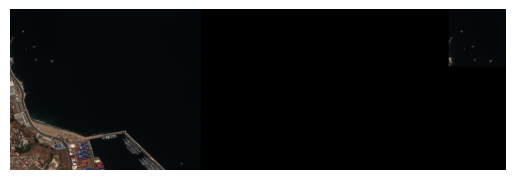

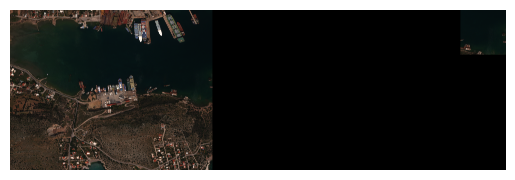

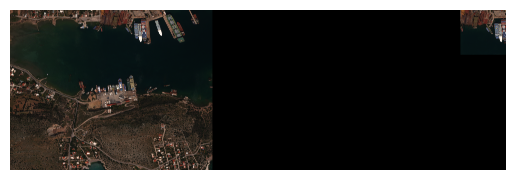

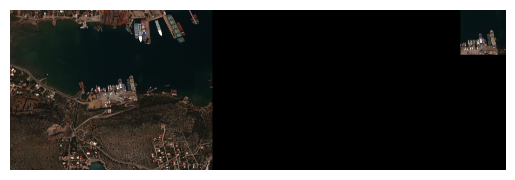

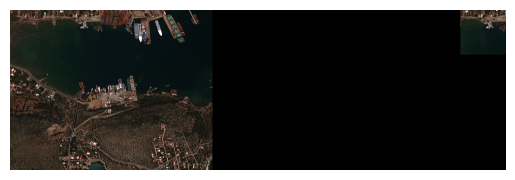

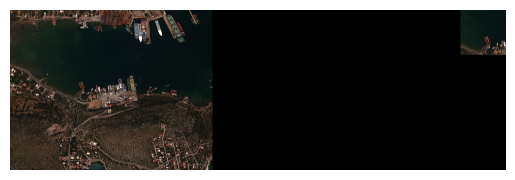

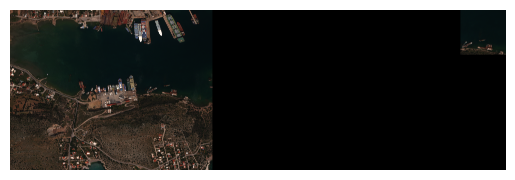

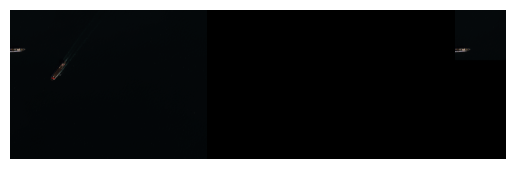

In [8]:
for prefix in list(intersection)[:3]:
    xView_image_path = os.path.join("xView", "train_images", f"{prefix}.tif")
    xView_image = cv2.imread(xView_image_path)

    for image in shipRSImages[prefix]:
        shipRS_image_path = os.path.join("ShipRSImageNet_V1", "VOC_Format", "JPEGImages", image)
        shipRS_image = cv2.imread(shipRS_image_path)

        xView_image_padded, shipRS_image_padded = pad_images(xView_image, shipRS_image)

        combined_image = np.hstack((xView_image_padded, shipRS_image_padded))

        plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

After close inspection, it can be confirmed that the ShipRS images pulled from the xView dataset are zoomed in portions of xView images

### Now: attempt to incorporate new images into ShipRS

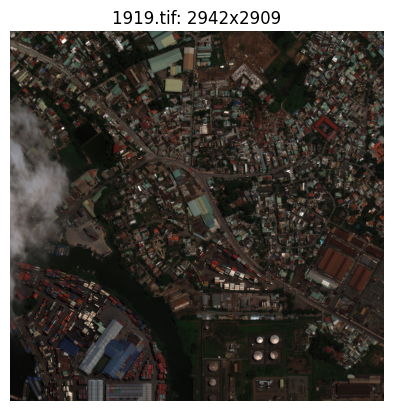

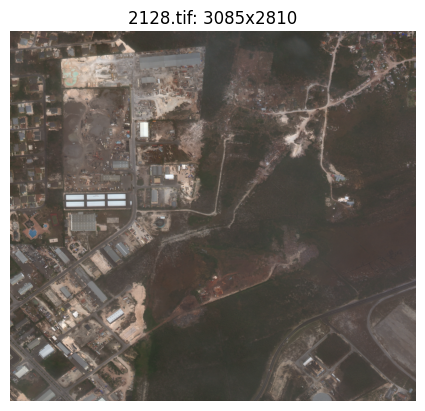

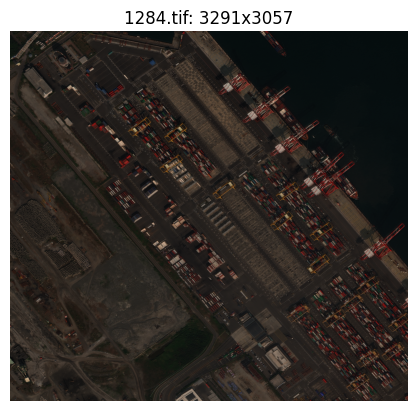

In [12]:
for image in list(difference)[:3]:
    path = os.path.join("xView", "train_images", f"{image}.tif")
    img = mpimg.imread(path)

    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    height,width = img.shape[:2]
    plt.title(f"{image}.tif: {width}x{height}")
    plt.show()
    plt.close()

The image sizes are huge which would be difficult for a computer vision model to process. According to ShipRS authors: "Since the image in xView is huge for training, we slice them into 930×930 pixels with 150 pixels overlap to produce 532 images and relabeled them with both horizontal bounding box and oriented bounding box." Note that dealing with large images often pose a problem for CV tasks because of the large amount of GPU memory required. Therefore, it's neccessary to normalize images in difference to the 930x930 sizing.

{
    "crs": {
        "properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"},
        "type": "name"
    },
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "bounds_imcoords": "2712,1145,2746,1177",
                "edited_by": "wwoscarbecerril",
                "cat_id": "1040010028371A00",
                "type_id": 73,
                "ingest_time": "2017/07/24 12:49:09.118+00",
                "index_right": 2356,
                "image_id": "2355.tif",
                "point_geom": "0101000020E6100000616E4E6406A256C03BE6ADA0D6212D40",
                "feature_id": 374410,
                "grid_file": "Grid2.shp"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[-90.53169885094464, 14.56603647302396], [-90.53169885094464, 14.56614473506768], [-90.53158140073565, 14.56614473506768], [-90.53158140073565, 14.56603647302396], [-90.53169885094464, 14.56603647302396]]]
            }
        }, 
        {
            "type": "Feature",
            "properties": {
                "bounds_imcoords": "2720,2233,2760,2288",
                "edited_by": "wwoscarbecerril",
                "cat_id": "1040010028371A00",
                "type_id": 73,
                "ingest_time": "2017/07/24 17:26:05.701+00",
                "index_right": 2356,
                "image_id": "2355.tif",
                "point_geom": "0101000020E6100000042D0CC705A256C0004F7071E71F2D40",
                "feature_id": 394393,
                "grid_file": "Grid2.shp"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[-90.53167232380382, 14.562217332510999], [-90.53167232380382, 14.562407959236182], [-90.53153294103244, 14.562407959236182], [-90.53153294103244, 14.562217332510999], [-90.53167232380382, 14.562217332510999]]]
            }
        }, 
    ]
}

In [15]:
def load_annotations_as_df(annotations):
    with open(annotations, "r") as f:
        xview = json.load(f)

    features = xview["features"]

    filenames, databases, sources, resolutions, widths, heights, depths, xmins, ymins, xmaxs, ymaxs, classids = [], [], [], [], [], [], [], [], [], [], [], []

    for feature in features:
        properties = feature["properties"]
        filename = properties["image_id"]

        if filename[:-4] in difference:
            # Only add images of interest to the Dataframe
            bbox = properties["bounds_imcoords"]
            classid = properties["type_id"]

            bbox_coords = list(map(int, bbox.split(",")))
            xmin, ymin, xmax, ymax = bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3]

            filenames.append(filename)
            databases.append("WorldView 3")
            sources.append("xView")
            resolutions.append(0.3)
            widths.append(Image.open(os.path.join("xView", "train_images", filename)).width)
            heights.append(Image.open(os.path.join("xView", "train_images", filename)).height)
            depths.append(3)
            xmins.append(xmin)
            ymins.append(ymin)
            xmaxs.append(xmax)
            ymaxs.append(ymax)
            classids.append(classid)

    df = pd.DataFrame({
        "filename": filenames,
        "databases": databases,
        "sources": sources,
        "resolutions": resolutions,
        "widths": widths,
        "heights": heights,
        "depths": depths,
        "xmins": xmins,
        "ymins": ymins,
        "xmaxs": xmaxs,
        "ymaxs": ymaxs,
        "classids": classids,
    })

    return df

anotations = os.path.join("xView", "xView_train.geojson")
df = load_annotations_as_df(anotations)
df.head()

,filename,databases,sources,resolutions,widths,heights,depths,xmins,ymins,xmaxs,ymaxs,classids
0,2279.tif,WorldView 3,xView,0.3,3596,2725,3,3506,-80,3610,338,89
1,2279.tif,WorldView 3,xView,0.3,3596,2725,3,2654,33,2665,46,18
2,2279.tif,WorldView 3,xView,0.3,3596,2725,3,2637,32,2644,45,18
3,2279.tif,WorldView 3,xView,0.3,3596,2725,3,2700,27,2714,49,73
4,2279.tif,WorldView 3,xView,0.3,3596,2725,3,3179,35,3190,80,24


In [17]:
fishing_vessel_df = df.query("classids == 47")
fishing_vessel_df

,filename,databases,sources,resolutions,widths,heights,depths,xmins,ymins,xmaxs,ymaxs,classids
159,2279.tif,WorldView 3,xView,0.3,3596,2725,3,2969,1408,2997,1425,47
346,2547.tif,WorldView 3,xView,0.3,4135,3275,3,313,704,387,915,47
864,2128.tif,WorldView 3,xView,0.3,3085,2810,3,2832,99,2846,128,47
1898,2599.tif,WorldView 3,xView,0.3,3483,2740,3,246,2161,297,2209,47
5222,2008.tif,WorldView 3,xView,0.3,4986,3181,3,4840,1383,4957,1408,47
...,...,...,...,...,...,...,...,...,...,...,...,...
32173,128.tif,WorldView 3,xView,0.3,3093,2606,3,3007,382,3030,405,47
32174,128.tif,WorldView 3,xView,0.3,3093,2606,3,2994,391,3013,413,47
32175,128.tif,WorldView 3,xView,0.3,3093,2606,3,3023,379,3042,398,47
32176,128.tif,WorldView 3,xView,0.3,3093,2606,3,3043,367,3061,385,47


In [18]:
len(fishing_vessel_df.filename.unique())

25

445 instances of fishing vessel class and 25 images!